# GSA workflow tutorial
The goal of this session is to give a flavour of Sensitivity Analysis by application  of several methods to a simple rainfall-runoff model.

The uncertain inputs subject to SA are the model parameters. The aim is to assess the impact of the uncertainty in these parameters on the model's ability to reproduce streamflow observations, as measured by different
performance metrics:
- the Root Mean Squared Error (RMSE)
- the volumetric bias (BIAS)

The analysis will be conducted using the [SAFE(R/Python/Matlab) Toolbox](https://safetoolbox.info) (Pianosi et al., 2015).

Programme:

 1. **Model setup and One-At-a-Time Sensitivity Analysis (OAT)**:
    Load the data and get confident with the rainfall-runoff model (Hymod)

 2. **Visual and qualitative Global Sensitivity Analysis (GSA)**:
    Perform Monte Carlo simulations (forward propagation of uncertainty), i.e.
    sample the model parameters within their ranges and run the model to
    obtain an ensemble of runoff predictions. Use a visual and qualitative
    GSA method for a preliminary assessment of sensitivity (scatterplots).

 3. **Regional Sensitivity Analysis (RSA)**:
    Use RSA to formally assess the effect of parameter variations on the model 
    outputs.
    (Young et al., 1978; Spear and Hornberger, 1980; Saltelli et al., 2008)
    
 4. **Regional Sensitivity Analysis based on grouping**: 
    Use RSA based on grouping to assess the output sensitivity without 
    specifying a single threshold on output values.
    (Wagener et al., 2001)
 
For further exploration after the course (try another GSA method):
     
5. **Variance-Based Sensitivity Analysis (VBSA)**:
Use VBSA to measure output sensitivity and compare with RSA results.
(Sobol', 1990; Homma and Saltelli, 1996; Saltelli et al. 1999;
Saltelli et al., 2008; Saltelli et al. 2010)

Throughout the session, we will also investigate the impact of several
key choices on SA results:
Throughout the session, we will also examine the impact of several key choices on SA results: <br> 
- the threshold value for RSA 
- the output (scalar) metric
- the sample size for the Monte Carlo simulations
- the parameter ranges
- the SA method
Further investigation of these choices can be found in Noacco et al.
(2019), and a general discussion on the topic is also provided in
Pianosi et al. (2016) and in Wagener and Pianosi (2019). The choice of
sample size is more specifically discussed in Sarrazin et al. (2016).

**Hymod model**:

We will use the Hymod (Boyle 2001; Wagener et al. 2001) model, which
produces a time series of streamflow predictions as output. The model is
composed of a soil moisture accounting routine, and a flow routing routine,
which in its turn is composed of a fast and a slow routing pathway.
The model is applied to the Leaf catchment in the USA (Sorooshian et al.,
1983).

![hymod_model](images/hymod_model.png)

Hymod includes 5 parameters:
- **Sm**: the maximum soil moisture (mm) (soil moisture)
- **beta**: the exponent in the soil moisture (-) (soil moisture)
- **alfa**: the partition coefficient (-) (routing)
- **Rs**: the slow reservoir coefficient (-) (routing)
- **Rf**: the fast reservoir coefficient (-) (routing)

The model is applied to the Leaf catchment in the USA (Sorooshian et al., 1983).

![leaf_catchment](images/leaf_catchment.png)

The model forcing input data are:
- 1-year daily observations of rainfall (R) [column 1 in LeafCatch.txt]
- 1-year daily observations potential evaporation (PE) [column 2 in the file
LeafCatch.txt]

We will also used output measurements:
- 1-year daily observations of streamflow (Q) [column 3 in LeafCatch.txt]

For this application, we can use the following ranges of feasible variations of the parameters:
- SM ∈ [0,400] (mm)
- beta ∈ [0,2] (-)
- alfa ∈ [0,1] (-)
- RS ∈ [0,0.1] (-)
- RF ∈ [0.1,1] (-)



## Import libraries

In [1]:
from __future__ import division, absolute_import, print_function

import os
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import scipy.stats as st

# Module to perform Regional Sensitivity Analysis:
import SAFEpython.RSA_thres as RSA_tr
# Module to perform Regional Sensitivity Analysis based on grouping:
import SAFEpython.RSA_groups as RSA_gp
# Module to perform Variance-Based Sensitivity Analysis:
import SAFEpython.VBSA as VB
# Module to visualize the results:
import SAFEpython.plot_functions as pf
# Module to execute the model
from SAFEpython.model_execution import model_execution
# Functions to perform the input sampling
from SAFEpython.sampling import AAT_sampling, AAT_sampling_extend
# Function to aggregate results across bootstrap resamples and to calculate RMSE:
from SAFEpython.util import aggregate_boot, RMSE
# Module that simulates the HyMod model:
from SAFEpython import HyMod

# Import the additional function BIAS in the BIAS.py module
from BIAS import BIAS

## 1. Model setup and One-At-a-Time Sensitivity Analysis

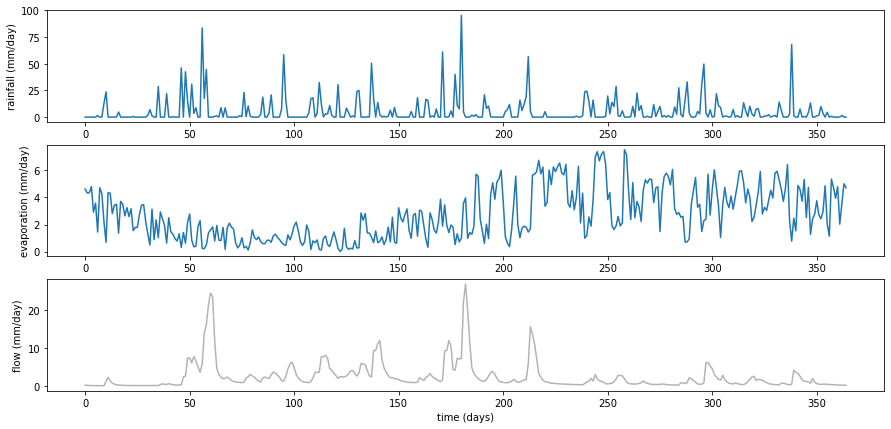

In [2]:
# Specify the directory where the data are stored 
# (CHANGE IT TO YOUR OWM PATH BEFORE RUNNING!!)
mydir = 'data'

# Load data and plot the data (one year of daily observations of rainfall, 
# potential evaporation and flow):

# Load data:
data = np.genfromtxt(mydir +'//LeafCatch.txt', comments='%')
rain = data[0:365, 0] # select the first year of data
evap = data[0:365, 1]
flow = data[0:365, 2]
warmup = 30 # Model warmup period (days)

# Plot data:
plt.figure(figsize=[15,7])
plt.subplot(311); plt.plot(rain); plt.ylabel('rainfall (mm/day)')
plt.subplot(312); plt.plot(evap); plt.ylabel('evaporation (mm/day)')
plt.subplot(313); plt.plot(flow, color=[0.7, 0.7, 0.7]); plt.ylabel('flow (mm/day)')
plt.xlabel('time (days)')
plt.show()

In [3]:
# Set the parameters to some tentative values, run the model and plot the 
# resulting streamflow time series:

def oat_function(Sm = 200, beta = 0.5, alpha = 0.7, Rs = 0.05, Rf = 0.6):
    # Set a tentative parameterization:
    param = np.array([Sm, beta, alpha, Rs, Rf]) # Sm (mm), beta (-), alfa (-), Rs (-), Rf (-)
    # Run simulation:
    flow_sim, _, _ = HyMod.hymod_sim(param, rain, evap)
    # Plot results:
    plt.figure(figsize=[15,3])
    plt.plot(flow, color=[0.7, 0.7, 0.7]) # observed flow
    plt.plot(flow_sim, 'k') # simulated flow
    plt.ylabel('flow (mm/day)')
    plt.xlabel('time (days)')
    plt.legend(['obs', 'sim'])
    plt.show()
    
interact(oat_function, Sm = (0, 400, 1), beta = (0, 2, 0.1), alpha = (0,1,0.1), Rs = (0,0.1,0.01), Rf = (0.1,1,0.1))

interactive(children=(IntSlider(value=200, description='Sm', max=400), FloatSlider(value=0.5, description='bet…

<function __main__.oat_function(Sm=200, beta=0.5, alpha=0.7, Rs=0.05, Rf=0.6)>

**To do**:
One-At-a-Time (OAT) effect: change one parameter (e.g. alfa) and repeat the previous steps.
- What is the effect of varying this parameter (and the others)?
- Which parameter controls which characteristic (timing, peak, recession phase, etc.) of the simulated flow time series?
- Which parameters seem to mostly influence the output?
- What are the pros and cons of OAT sensitivity analysis?

## 2. Visual and qualitative Global Sensitivity Analysis
 In this section, we run Monte Carlo (MC) simulations of the model against a certain number of input (parameter) samples. Each model simulation provides a times series of runoff predictions. To measure the accuracy of each of these times series with respect to observations, we define two aggregate output metrics to be used for the subsequent steps:
- the Root Mean Squared Error (RMSE) of the streamflow predictions
- the volumetric Bias (BIAS) of the streamflow predictions

Input (parameter) sampling (this involves a number of choices that will be  assessed and revised later on):

In [4]:
# Define input variability space
X_Labels = ['Sm', 'beta', 'alfa', 'Rs', 'Rf'] # Name of parameters (used to customize plots)
M = len(X_Labels) # Number of parameters
distr_fun = st.uniform # Parameter distributions
xmin = [0,   0, 0, 0.0, 0.1] # Parameter ranges (lower bound)
xmax = [400, 2, 1, 0.1, 1.0] # Parameter ranges (upper bound)
# The shape parameters of the uniform distribution are the lower limit and the
# difference between lower and upper limits:
distr_par = [np.nan] * M
for i in range(M):
    distr_par[i] = [xmin[i], xmax[i] - xmin[i]]

# Choose sampling strategy and size:
samp_strat = 'lhs' # sampling strategy
# options:
# 'lhs' = Latin Hypercube sampling
# 'rsu' = Random uniform sampling
N = 150 # Choose the number of samples

# Perform sampling:
X = AAT_sampling(samp_strat, M, distr_fun, distr_par, N)
# If you want to see what the sample 'X' looks like:
print(X[0:10, :]) # Print to screen the first 10 samples

[[3.96268759e+02 1.23054208e+00 8.11377468e-01 1.73126318e-02
  3.80794438e-01]
 [1.76579042e+02 3.10422135e-02 6.98188085e-02 3.52899076e-02
  6.26707808e-01]
 [2.24749449e+01 7.54138468e-01 3.97558005e-01 2.30351194e-02
  1.11769479e-01]
 [3.63844713e+02 7.19076262e-01 4.56087624e-01 5.32043977e-02
  7.88358721e-01]
 [3.41782238e+02 8.90716937e-01 7.38175626e-01 8.17301462e-02
  1.36664394e-01]
 [2.38728718e+02 1.67092013e+00 3.34146797e-01 2.19895676e-02
  9.16570164e-01]
 [1.86983130e+01 1.96676640e+00 5.08941956e-01 9.74882353e-02
  5.47672274e-01]
 [1.93870479e+02 2.66127815e-01 5.40744594e-02 6.16592027e-02
  3.43911087e-01]
 [2.03988639e+02 1.12401011e+00 7.94748138e-01 2.73585333e-02
  2.21198134e-01]
 [2.00865362e+02 1.19019524e+00 1.65295785e-01 7.99718286e-02
  5.86059098e-01]]


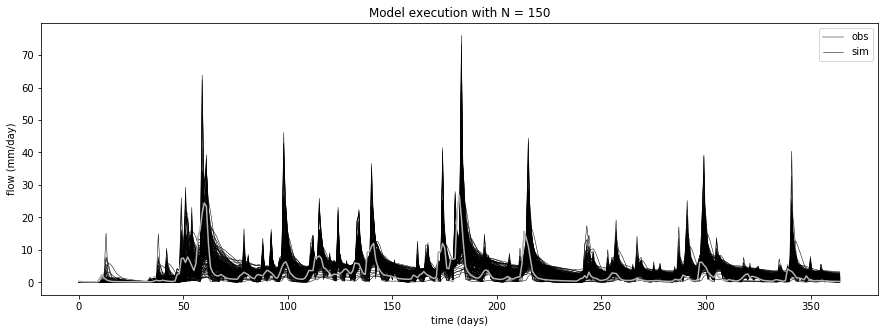

In [5]:
# Execute the model against all the input samples in 'X':
QQ = model_execution(HyMod.hymod_sim, X, rain, evap)

# Plot Monte Carlo (MC) simulations results and compare with data:
plt.figure(figsize=[15,5])
plt.plot(flow, color=[0.7, 0.7, 0.7]) # plot for legend
plt.plot(np.transpose(QQ), 'k', linewidth = 0.5)
plt.plot(flow, color=[0.7, 0.7, 0.7])
plt.ylabel('flow (mm/day)'); plt.xlabel('time (days)')
plt.legend(['obs', 'sim'])
plt.title("Model execution with N = %d" % N)
plt.show()

### Let's do it more interactive!

In [6]:
def sampling_function(samp_strat='lhs', N = 150):
    
    # Perform sampling:
    X = AAT_sampling(samp_strat, M, distr_fun, distr_par, N)
    
    # Execute the model against all the input samples in 'X':
    QQ = model_execution(HyMod.hymod_sim, X, rain, evap)

    # Plot Monte Carlo (MC) simulations results and compare with data:
    plt.figure(figsize=[15,5])
    plt.plot(flow, color=[0.7, 0.7, 0.7]) # plot for legend
    plt.plot(np.transpose(QQ), 'k',linewidth = 0.5);
    plt.plot(flow, color=[0.7, 0.7, 0.7])
    plt.ylabel('flow (mm/day)'); plt.xlabel('time (days)')
    plt.legend(['obs', 'sim'])
    plt.title("Model execution with N = %d" % N)
    plt.show()

interact(sampling_function,samp_strat=['lhs','rsu'], N = (10,200,10))

interactive(children=(Dropdown(description='samp_strat', options=('lhs', 'rsu'), value='lhs'), IntSlider(value…

<function __main__.sampling_function(samp_strat='lhs', N=150)>

In [7]:
# Aggregate time series into various scalar output metric(s):
YY = np.nan * np.ones((N, 2))
YY[:, 0] = RMSE(QQ[:, warmup:365], flow[warmup:365])
YY[:, 1] = BIAS(QQ[:, warmup:365], flow[warmup:365])

# If you want to see what the samples in 'YY' looks like:
print(YY.shape) # Check the shape of 'YY'
print(YY[0:10, :]) # Print to screen the first 10 samples

(150, 2)
[[3.70930185 1.02593212]
 [3.13378654 0.47229784]
 [3.96869748 1.49415452]
 [2.895953   0.71011237]
 [3.87300186 0.8739878 ]
 [3.31036487 1.32767693]
 [3.42963327 2.0122768 ]
 [3.02249525 0.63811386]
 [4.01271766 1.26968603]
 [2.82718897 1.35610709]]


In [8]:
def output_metric_interact(metric):
    if metric == 'RMSE': 
        i = 0
    elif metric == 'BIAS': 
        i = 1
    
    Y = YY[:, i]; 
    Y_Label = metric

    # Scatter plots of the output metric against input samples:
    plt.figure(figsize=[15,3])
    pf.scatter_plots(X, Y, Y_Label=Y_Label, X_Labels=X_Labels)
    plt.title("Scatter plots with N = %d" % N + ', ' + Y_Label, loc='right')
    plt.show()
  
interact(output_metric_interact, metric = ['RMSE', 'BIAS'])
# AA = interact(output_metric, metric = ['RMSE', 'BIAS'])
# AA.widget.kwargs['metric']

interactive(children=(Dropdown(description='metric', options=('RMSE', 'BIAS'), value='RMSE'), Output()), _dom_…

<function __main__.output_metric_interact(metric)>

**To do**:
- From these scatter plots, which parameter would you say is most influential? Why?
- Are there parameters that are not influential at all?

## 3. Regional Sensitivity Analysis
In this section, we formally assess the sensitivity of the output metrics (RMSE and BIAS) to the model parameters through the Regional Sensitivity Analysis (RSA) method.

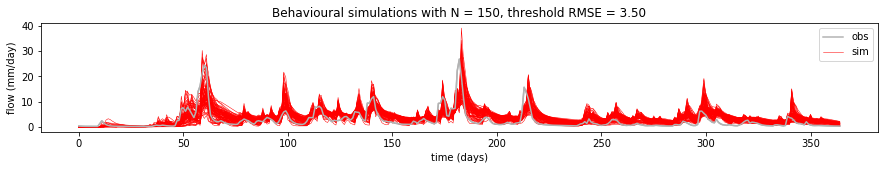

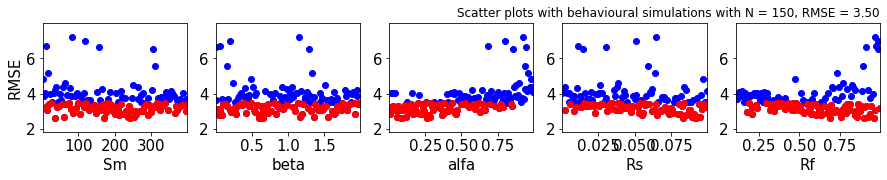

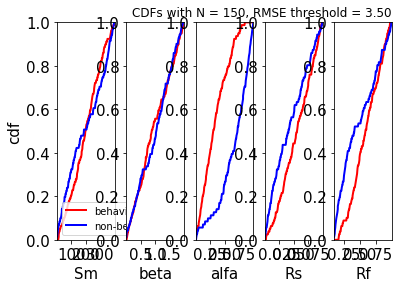

[0.1440542  0.11196292 0.52290961 0.22142984 0.30718488]


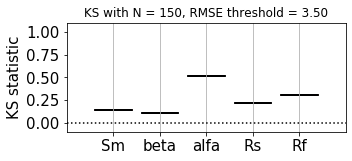

In [11]:
def RSA_function(metric = 'RMSE',threshold = 3.5):

    if metric == 'RMSE': 
        i = 0
        if threshold < 3: # for RMSE threshold lower than 3 you get an error
            threshold = 3
    elif metric == 'BIAS': # for BIAS threshold higher than 2.5 you get an error
        i = 1
        if threshold > 2.5:
            threshold = 2.5
    
    Y = YY[:, i]; 
    Y_Label = metric
    
    # Use the function RSA_indices_thres to split into behavioural (Y<threshold)
    # and non-behavioural (Y>threshold) sample:
    mvd, _, _, idxb = RSA_tr.RSA_indices_thres(X, Y, threshold)
    # To learn what the function 'RSA_indices_thres' does, type:
    # help(RSA_tr.RSA_indices_thres)
    # idxb: indices of behavioural samples

    # Plot behavioural MC simulations:
    QQb = QQ[idxb, :]
    plt.figure(figsize=[15,2])
    plt.plot(flow, color=[0.7, 0.7, 0.7]) # plot for legend
    plt.plot(np.transpose(QQb), 'r', linewidth = 0.5);
    plt.plot(flow, color=[0.7, 0.7, 0.7])
    plt.ylabel('flow (mm/day)'); plt.xlabel('time (days)')
    plt.legend(['obs', 'sim'])
    plt.title("Behavioural simulations with N = %d" % N + ', threshold ' + Y_Label + ' = %2.2f' % threshold)
    plt.show()

    # Replot the results with the function `scatter_plots` highlighting the
    # behavioural parameterizations:
    plt.figure(figsize=[15,2])
    pf.scatter_plots(X, Y, Y_Label=Y_Label, X_Labels=X_Labels, idx=idxb)
    plt.title("Scatter plots with behavioural simulations with N = %d" % N + ', ' + Y_Label  + " = %2.2f" % threshold, \
              loc='right')
    plt.show()
    # (red = behavioural, blue = non-behavioural)

    # Plot CDFs of behavioural and non-behavioural input samples: (HOW CAN WE CHANGE THE SIZE OF THIS FIGURE?)
    fig_cdfs = RSA_tr.RSA_plot_thres(X, idxb, X_Labels=X_Labels)
    plt.title("CDFs with N = %d" % N + ', ' + Y_Label + " threshold = %2.2f" % threshold, loc='right')
    plt.show()

    # Check the value of KS statistic maximum vertical distance between the two
    # CDFs of the inputs):
    print(mvd)

    # Plot the KS statistic:
    plt.figure(figsize=[5,2])
    pf.boxplot1(mvd, X_Labels=X_Labels, Y_Label='KS statistic')
    plt.title("KS with N = %d" % N + ', ' + Y_Label + " threshold = %2.2f" % threshold)
    plt.show()

RSA_function(metric = 'RMSE', threshold = 3.5)

**To do**:
- From the CDF plots, which parameter would you say are the most influential? Why?
- Are these results consistent with the visual analysis of the scatter plots?

**To do**:
- Are the KS values consistent with the visual inspection of the CDF plots?
- Did you get the same KS values as the other participants? Why?

### 3.1 Assess the effect of the change in threshold

**To do**: Run the cell below to plot an interactive figure and choose a different **threshold**
- How have the results changed by changing the threshold of the output metric?

In [13]:
# Plot the interactive figure
interact(RSA_function, metric = ['RMSE', 'BIAS'], threshold = (0.5,5,0.5))

interactive(children=(Dropdown(description='metric', options=('RMSE', 'BIAS'), value='RMSE'), FloatSlider(valu…

<function __main__.RSA_function(metric='RMSE', threshold=3.5)>

### 3.2 Assess the effect of the definition of output metric

**To do**: Choose a different **output metric** (on the interactive figure above).
- Does the answer change depending on the performance metric chosen? Why?

**References**:

Homma and Saltelli (1996). Importance measures in global sensitivity
analysis of nonlinear models. Reliability Engineering & System Safety.
52(1). 1-17.

Noacco et al. (2019). Matlab/R workflows to assess critical choices in
Global Sensitivity Analysis using the SAFE toolbox. MethodsX. 6. 2258-2280.

Pianosi et al. (2015). A Matlab toolbox for Global Sensitivity Analysis.
Environmental Modelling and Software. 70. 80-85.

Pianosi et al. (2016). Sensitivity analysis of environmental models:
A systematic review with practical workflow. Environmental Modelling and
Software. 79. 214-232.

Saltelli et al. (1999). A quantitative model-independent method for global
sensitivity analysis of model output. Technometrics. 41(1). 39-56.

Saltelli et al. (2008). Global Sensitivity Analysis, The Primer, John Wiley
Sons. Ltd. Chichester, UK.

Saltelli et al. (2010). Variance based sensitivity analysis of model output.
Design and estimator for the total sensitivity index, Computer Physics
Communications. 181. 259-270.

Sarrazin et al. (2016). Global Sensitivity Analysis of environmental models:
Convergence and validation. Environmental Modelling and Software. 79.
135-162.

Sobol' (1990). Sensitivity estimates for nonlinear mathematical models,
Matematicheskoe Modelirovanie. 2. 112-118 (in Russian). translated in
English (1993). Mathematical Modelling and Computational Experiments. 1.
407-414.

Sorooshian at al. (1983). Evaluation of maximum likelihood parameter
estimation techniques for conceptual rainfall-runoff models: Influence of
calibration data variability and length on model credibility. Water Resour.
Res. 19. 251-259.

Spear and Hornberger (1980). Eutrophication in peel inlet e II.
Identification of critical uncertainties via generalized sensitivity analysis.
Water Research. 14(1). 43-49.

Wagener et al. (2001). A framework for development and application of
hydrological models. Hydrol. Earth Syst. Sci.. 5. 13-26.

Wagener and Pianosi (2019). What has Global Sensitivity Analysis ever done for 
us? A systematic review to support scientific advancement and to inform policy-
making in earth system modelling. Earth-Science Reviews. 194. 1-18.

Young et al. (1978). Modelling badly defined systems: some further thoughts.
In: Proceedings SIMSIG Conference. Canberra. 24-32.

Script prepared by Fanny Sarrazin, February 2022
fanny.sarrazin@ufz.de"""